# Fundamental Diagrams at Measurement Lines

This notebook demonstrates the calculation of density, speed, and flow for pedestrian trajectories at a measurement line, based on the method described in Adrian et al., 2024: [Continuity Equation and Fundamental Diagram of Pedestrians](https://arxiv.org/abs/2409.11857).

The calculations rely on a Voronoi decomposition of the available space, adapted to determine each pedestrian's contribution to the measurement line. Specifically, the proportion of the line intersected by a pedestrian's Voronoi cell defines their contribution.

The speed at the measurement line ($v_l$) is calculated as:

$$v_{l} = \sum_i v_{i,n_{l}} \cdot w_{i,l},$$

where $v_{i,n_{l}}$ is the speed of pedestrian $i$ orthogonal to the measurement line, and $w_{i,l}$ is their proportional contribution to the line. Density and flow are computed using similar principles.

This method measures flow perpendicular to a line, aligning with the classical physical definition. It is particularly effective for analyzing directional flows (e.g., uni- or bidirectional). However, for non-directional flows over wide areas, alternative measurement methods may be more appropriate.

## Analysis Set-up

The first step is to load the trajectory data. This guide analyzes data from four corridor experiments: two with unidirectional flows and two with bidirectional flows. The measurement line is aligned orthogonally to the main movement direction in all experiments.

In [1]:
from pedpy import TrajectoryUnit

files = {
    "unidirectional 1": (
        "demo-data/uni-directional/traj_UNI_CORR_500_08.txt",
        TrajectoryUnit.METER,
    ),
    "unidirectional 2": (
        "demo-data/uni-directional/traj_UNI_CORR_500_03.txt",
        TrajectoryUnit.METER,
    ),
    "bidirectional 1": (
        "demo-data/bi-directional/bi_corr_400_b_08.txt",
        TrajectoryUnit.CENTIMETER,
    ),
    "bidirectional 2": (
        "demo-data/bi-directional/bi_corr_400_b_03.txt",
        TrajectoryUnit.CENTIMETER,
    ),
}

In [2]:
import pathlib

from pedpy import load_trajectory

trajectories = {}
for name, (path, unit) in files.items():
    trajectories[name] = load_trajectory(
        trajectory_file=pathlib.Path(path), default_unit=unit
    )

KeyboardInterrupt: 

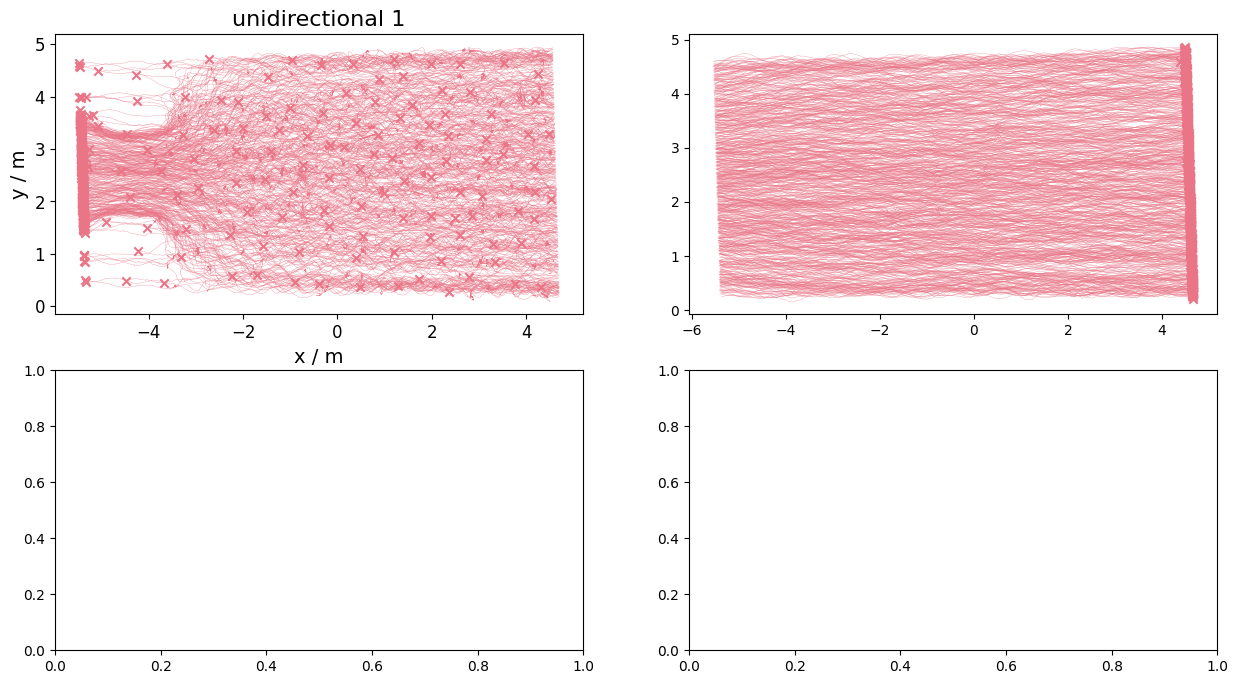

In [3]:
import matplotlib.pyplot as plt

from pedpy import plot_measurement_setup


def format_axis(ax, xlabel, ylabel, title, legend=True):
    """Format axis."""
    label_size = 14
    title_size = 16
    legend_size = 12
    tick_size = 12

    ax.set_xlabel(xlabel, fontsize=label_size)
    ax.set_ylabel(ylabel, fontsize=label_size)
    ax.tick_params(axis="both", which="major", labelsize=tick_size)
    ax.set_title(title, fontsize=title_size)
    if legend:
        ax.legend(fontsize=legend_size)


fig, axs = plt.subplots(2, int(len(trajectories) / 2), figsize=(15, 8))

for (name, trajectory), ax in zip(
    trajectories.items(), axs.ravel(), strict=False
):
    plot_measurement_setup(
        traj=trajectory,
        axes=ax,
        traj_width=0.2,
        traj_end_marker="x",
    )
    format_axis(ax, "x / m", "y / m", name, legend=False)

fig.tight_layout()
plt.show()

The plot above shows the trajectories of the experimental data analyzed in this Notebook, including both unidirectional and bidirectional experiments. Each red line represents a pedestrian's trajectory, with their ending positions marked by an "x."

Next the {class}`walkable area <geometry.WalkableArea>` of the experiment is defined.


In [4]:
from pedpy import WalkableArea

walkable_areas = {
    "unidirectional 1": WalkableArea(
        # complete area
        [(-6.5, 6.5), (-6.5, -1.5), (6.5, -1.5), (6.5, 6.5)],
        obstacles=[
            # lower Wall:
            [(-6.0, 0.0), (5.0, 0.0), (5.0, -1.0), (-6.0, -1.0)],
            # upper Wall:
            [(-6.0, 5.0), (5.0, 5.0), (5.0, 6.0), (-6.0, 6.0)],
        ],
    ),
    "unidirectional 2": WalkableArea(
        # complete area
        [(-6.5, 6.5), (-6.5, -1.5), (6.5, -1.5), (6.5, 6.5)],
        obstacles=[
            # lower Wall:
            [(-6.0, 0.0), (5.0, 0.0), (5.0, -1.0), (-6.0, -1.0)],
            # upper Wall:
            [(-6.0, 5.0), (5.0, 5.0), (5.0, 6.0), (-6.0, 6.0)],
        ],
    ),
    "bidirectional 1": WalkableArea(
        # complete area
        [(-6.5, 6.5), (-6.5, -1.5), (5.5, -1.5), (5.5, 6.5)],
        obstacles=[
            # lower Wall:
            [(-6.0, 0.0), (5.0, 0.0), (5.0, -1.0), (-6.0, -1.0)],
            # upper Wall:
            [(-6.0, 4.0), (5.0, 4.0), (5.0, 5.0), (-6.0, 5.0)],
        ],
    ),
    "bidirectional 2": WalkableArea(
        # complete area
        [(-6.5, 6.5), (-6.5, -1.5), (5.5, -1.5), (5.5, 6.5)],
        obstacles=[
            # lower Wall:
            [(-5.0, 0.0), (5.0, 0.0), (5.0, -1.0), (-5.0, -1.0)],
            # upper Wall:
            [(-5.0, 4.1), (5.0, 4.1), (5.0, 5.0), (-5.0, 5.0)],
        ],
    ),
}

To obtain correct results, it is important that the measurement line is orthogonal to the main direction of movement.


In [5]:
from pedpy import MeasurementLine

measurement_lines = {
    "unidirectional 1": MeasurementLine([(0.0, 0.0), (0.0, 5.0)]),
    "unidirectional 2": MeasurementLine([(0.0, 0.0), (0.0, 5.0)]),
    "bidirectional 1": MeasurementLine([(0.0, 0.0), (0.0, 4.0)]),
    "bidirectional 2": MeasurementLine([(0.0, 0.0), (0.0, 4.0)]),
}

The entire setup, including trajectories, geometry, and measurement lines looks like this:


In [ ]:
fig, axs = plt.subplots(2, int(len(trajectories) / 2), figsize=(15, 11))

for (name, trajectory), ax in zip(
    trajectories.items(), axs.ravel(), strict=False
):
    plot_measurement_setup(
        traj=trajectory,
        walkable_area=walkable_areas[name],
        measurement_lines=[measurement_lines[name]],
        axes=ax,
        traj_width=0.2,
        traj_end_marker="x",
        ma_color="g",
        ma_line_color="g",
        ma_alpha=0.2,
        ml_color="b",
    )
    format_axis(ax, "x / m", "y / m", name, legend=False)
fig.tight_layout()
plt.show()

## Calculate Voronoi Polygons

The Voronoi decomposition is used to assign cells to each pedestrian and to calculate density, speed, and flow at a measurement line. To ensure accuracy, it is highly recommended to apply a cutoff when calculating Voronoi polygons. Without a cutoff, pedestrians at the edges of a group may influence disproportionately large areas, leading to inaccuracies.

Please note that computing Voronoi polygons may take some time.


In [7]:
from pedpy.methods.method_utils import (
    Cutoff,
    compute_individual_voronoi_polygons,
)

individual_cutoffs = {}

In [8]:
individual_cutoffs["unidirectional 1"] = compute_individual_voronoi_polygons(
    traj_data=trajectories["unidirectional 1"],
    walkable_area=walkable_areas["unidirectional 1"],
    cut_off=Cutoff(radius=0.8, quad_segments=3),
)

In [9]:
individual_cutoffs["unidirectional 2"] = compute_individual_voronoi_polygons(
    traj_data=trajectories["unidirectional 2"],
    walkable_area=walkable_areas["unidirectional 2"],
    cut_off=Cutoff(radius=0.8, quad_segments=3),
)

In [10]:
individual_cutoffs["bidirectional 1"] = compute_individual_voronoi_polygons(
    traj_data=trajectories["bidirectional 1"],
    walkable_area=walkable_areas["bidirectional 1"],
    cut_off=Cutoff(radius=0.8, quad_segments=3),
)

In [11]:
individual_cutoffs["bidirectional 2"] = compute_individual_voronoi_polygons(
    traj_data=trajectories["bidirectional 2"],
    walkable_area=walkable_areas["bidirectional 2"],
    cut_off=Cutoff(radius=0.8, quad_segments=3),
)

## Determine the Species

A species represents a set of pedestrians that encouters the measurement line frome the same side.
Since there are two possible main directions of movement in which the line can be approached orthogonally, pedestrians are divided into two species, referred to as Species 1 and Species 2.

To determine which species a pedestrian belongs to, the direction of their velocity at the first frame $t_{i,l}$​, where their Voronoi cell intersects the line, is analyzed.

A movement factor $m_i$​ is defined for each pedestrian $i$ as the sign of the orthogonal velocity component $n \cdot v(t_{i,l})$:

$$m_i = sign \Big( n \cdot v(t_{i,l}) \Big).$$

Here:

- $n$ is the normal vector of the measurement line
- $v(t_{i,l})$ is the velocity of pedestrian $i$ when they reach the line $l$.

Pedestrians with $m_i=1$ have the same main movement direction and belong to Species 1.
Pedestrian with $m_i=-1$ move in the opposite direction and belong to Species 2.

```{eval-rst}
.. figure:: images/species_determination.svg
    :align: center
```

This figure shows the frame where the species determination is made.
This decision is based on the first frame where a pedestrian's Voronoi cell intersects the measurement line. The direction of the current velocity at that moment determines the species assignment.

It is important to note that the decision is independent of whether the pedestrian crosses the line afterward.

In [12]:
from pedpy.methods.speed_calculator import compute_species

species = {}

for name in trajectories:
    species[name] = compute_species(
        individual_voronoi_polygons=individual_cutoffs[name],
        measurement_line=measurement_lines[name],
        trajectory_data=trajectories[name],
        frame_step=25,
    )

## Calculating Individual Velocity

We will calculate the individual velocity using the `compute_individual_speed` function.
Keep the following considerations in mind:

1. **Enable Velocity Calculation**:
   Ensure that the `compute_velocity` option is enabled to calculate the individual velocity.

2. **Frame Step Selection**:

   - The frame step determines how many frames before and after the current position are used to calculate movement.
   - **Choosing the frame step**:
     - A small frame step may result in noisy calculations.
     - A large frame step might overlook smaller movements, reducing accuracy.

3. **Handling Border Cases**:

   - The default speed calculation method is `BORDER_EXCLUDE`, which excludes trajectory values at the edges.
   - If these excluded values are required for subsequent calculations, this may lead to errors. Possible solutions include:
     - Cutting a few frames from the trajectory data used for Voronoi polygon calculations to ensure alignment.
     - Switching to a different speed calculation method.

4. **Alternative Speed Calculation Methods**:
   - Consider other speed calculation options if `BORDER_EXCLUDE` is unsuitable.
   - Refer to the [User Guide](user_guide) for details on available methods and their implications.


In [13]:
from pedpy.methods.speed_calculator import (
    SpeedCalculation,
    compute_individual_speed,
)

calculation_methods = {
    "unidirectional 1": SpeedCalculation.BORDER_SINGLE_SIDED,
    "unidirectional 2": SpeedCalculation.BORDER_EXCLUDE,
    "bidirectional 1": SpeedCalculation.BORDER_EXCLUDE,
    "bidirectional 2": SpeedCalculation.BORDER_EXCLUDE,
}

individual_speeds = {}

for name in trajectories:
    individual_speeds[name] = compute_individual_speed(
        traj_data=trajectories[name],
        frame_step=1,
        compute_velocity=True,
        speed_calculation=calculation_methods[name],
    )

## Calculating Speed Perpendicular to the Measurement Line

To calculate the total speed perpendicular to the measurement line in a specific frame, all pedestrians whose Voronoi polygons intersect with the measurement line are considered.

```{eval-rst}
.. figure:: images/voronoi_at_line.svg
    :align: center
```

The speed of an individual pedestrian is determined by multiplying their orthogonal speed with their proportion of the measurement line:

$$ v^\text{line}_i(t) = v_{i}(t) \cdot n_l \cdot \frac{w_i(t)}{w}.$$

Here:

- $w_i(t)$ is the length of the measurement line segment intersected by the pedestrian’s Voronoi cell.
- $w$ is the total length of the measurement line.
- $n_l$ is the unit normal vector to the measurement line.

```{eval-rst}
.. figure:: images/line_intersection_voronoi.svg
    :align: center
```

## Handling Opposite Movement Directions

Pedestrians in Species 2 move in the opposite main direction, which causes their velocities to have opposite signs. Adding these directly would result in the contributions of the two species canceling each other out.

To address this, the velocity of each pedestrian is adjusted by multiplying it with the movement factor $m$, which ensures consistent directionality in the calculations.

$$ v^S(t) = \sum_{i \in S} m \cdot v^\text{line}_i(t).$$

The total speed across the measurement line combines the contributions from both species:

$$ v^\text{line}(t) = v^{\mathrm{I}}(t) + v^{\mathrm{II}}(t).$$

## Allowing for Negative Velocities

This approach accommodates negative velocities within each species. Negative velocities may occur when a pedestrian:

- Stands still but wobbles their head, resulting in small velocity fluctuations.
- Crosses the measurement line multiple times, moving in both directions.

By accounting for such cases, this method ensures comprehensive and robust measurements of pedestrian movement.


In [14]:
from pedpy.methods.speed_calculator import compute_line_speed

speeds = {}
for name in trajectories:
    speeds[name] = compute_line_speed(
        individual_voronoi_polygons=individual_cutoffs[name],
        measurement_line=measurement_lines[name],
        individual_speed=individual_speeds[name],
        species=species[name],
    )

In [ ]:
from pedpy.plotting.plotting import plot_speed_at_line

fig, axs = plt.subplots(2, int(len(speeds) / 2), figsize=(15, 11))

for (name, speed_on_line), ax in zip(speeds.items(), axs.ravel(), strict=False):
    plot_speed_at_line(
        speed_at_line=speed_on_line,
        axes=ax,
        line_width=0.5,
    )
    format_axis(ax, "Frame", "Speed / m/s", f"Speed on line for {name}")

fig.tight_layout()
plt.show()

## Compute Line Density

The density along the measurement line is calculated based on the densities of the Voronoi cells of pedestrians, weighted by their proportional contribution to the line. The density for each species considers only the pedestrians belonging to that species.

$$ \rho^S(t) = \sum_{i \in S} \frac{1}{A_i(t)} \cdot \frac{w_i(t)}{w}.$$

Here:

- $A_i(t)$: The area of pedestrian $i$'s Voronoi cell.
- $\frac{w_i(t)}{w}$​: The fraction of the measurement line intersected by the Voronoi cell of pedestrian $i$.

The total density is obtained by combining the contributions from both Species 1 and 2:

$$ \rho^\text{line}(t) = \rho^{\mathrm{I}}(t) + \rho^{\mathrm{II}}(t)$$


In [16]:
from pedpy.methods.density_calculator import compute_line_density

densities = {}
for name in trajectories:
    densities[name] = compute_line_density(
        individual_voronoi_polygons=individual_cutoffs[name],
        measurement_line=measurement_lines[name],
        species=species[name],
    )

In [ ]:
from pedpy.plotting.plotting import plot_density_at_line

fig, axs = plt.subplots(2, int(len(densities) / 2), figsize=(15, 11))

for (name, density_on_line), ax in zip(
    densities.items(), axs.ravel(), strict=False
):
    plot_density_at_line(
        density_at_line=density_on_line,
        axes=ax,
        line_width=0.75,
        title=f"density on line for {name}",
    )
    format_axis(
        ax, "Frame", "Density / $m^{-2}$", f"Density on line for {name}"
    )

fig.tight_layout()
plt.show()

## Compute Line Flow

The calculation of flow is based on the flow equation:

$$
J = \rho \cdot v \cdot w
$$

To compute the flow, both the velocity orthogonal to the measurement line and the density are considered. Each species only accounts for the pedestrians representing that species. To handle the negative velocities of Species 2, the movement factor $m$ is applied.

The flow for a species $S$ is calculated as:

$$
j^S(t) = \sum_{i \in S} m_i \cdot v_i(t) \cdot n_{l} \cdot \frac{1}{A_i(t)} \cdot \frac{w_i(t)}{w}
$$

### Explanation of Symbols

- $j$: The flow
- $S$: The species for which the flow is calculated
- $i$: A pedestrian belonging to species $S$
- $m_i$: The movement factor for pedestrian $i$, determined during species assignment
- $v_i(t)$: The velocity of pedestrian $i$ at time $t$
- $n_{l}$: The orthogonal vector of the measurement line $l$
- $A_i(t)$: The area of the Voronoi cell for pedestrian $i$
- $w_i(t)$: The length of the measurement line intersected by the Voronoi cell of pedestrian $i$
- $w$: The total length of the measurement line

The total flow across the measurement line is obtained by combining the contributions from both species:

$$
j^\text{line}(t) = j^{\mathrm{I}}(t) + j^{\mathrm{II}}(t)
$$


In [18]:
from pedpy.methods.flow_calculator import compute_line_flow

flows = {}
for name in trajectories:
    flows[name] = compute_line_flow(
        individual_voronoi_polygons=individual_cutoffs[name],
        measurement_line=measurement_lines[name],
        species=species[name],
        individual_speed=individual_speeds[name],
    )

In [ ]:
from pedpy.plotting.plotting import plot_flow_at_line

fig, axs = plt.subplots(2, int(len(flows) / 2), figsize=(15, 11))

for (name, flow_on_line), ax in zip(flows.items(), axs.ravel(), strict=False):
    plot_flow_at_line(
        flow_at_line=flow_on_line,
        axes=ax,
        line_width=0.75,
        title=f"flow on line for {name}",
    )
    format_axis(ax, "Frame", "Flow / 1/s", f"Flow on line for {name}")

fig.tight_layout()
plt.show()

## Excluding Data from the Start and End Phases

Upon closer examination of the trajectory data from the first unidirectional experiment, it becomes evident that not all the data collected are meaningful for analysis. This is due to the way the experiment was conducted.

Toward the end of the experiment, participants were instructed to remain stationary. Consequently, although the data are technically usable, it may not contribute meaningfully to further analysis.

When analyzing on your own it is recommended to exclude data that lack substantive relevance.


In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(15, 11))

name = "unidirectional 1"

interval = [500, 2075]
plot_measurement_setup(
    axes=axs[0, 0],
    traj=trajectories[name],
    walkable_area=walkable_areas[name],
    measurement_lines=[measurement_lines[name]],
)
format_axis(axs[0, 0], "x / m", "y / m", f"Trajectories {name}", legend=False)
plot_speed_at_line(
    axes=axs[0, 1], speed_at_line=speeds[name], title=f"line speed for {name}"
)
axs[0, 1].plot([interval[0], interval[0]], [-0.1, 1.2], c="r")
axs[0, 1].plot([interval[1], interval[1]], [-0.1, 1.2], c="r")
format_axis(axs[0, 1], "Frame", "v / m/s", f"Line speed for {name}")

plot_density_at_line(
    axes=axs[1, 0],
    density_at_line=densities[name],
    title=f"line density for {name}",
)
axs[1, 0].plot([interval[0], interval[0]], [0, 4], c="r")
axs[1, 0].plot([interval[1], interval[1]], [0, 4], c="r")
format_axis(axs[1, 0], "Frame", "Density / $m^{-2}$", f"Density for {name}")

plot_flow_at_line(
    axes=axs[1, 1], flow_at_line=flows[name], title=f"line flow for {name}"
)
axs[1, 1].plot([interval[0], interval[0]], [0, 2.2], c="r")
axs[1, 1].plot([interval[1], interval[1]], [0, 2.2], c="r")
format_axis(axs[1, 1], "Frame", "J / 1/s", f"Flow for {name}")

fig.tight_layout()
plt.show()

In the plots above you can see the trajectories of the first unidirectional experiment as well as the line speed, line density and line flow for said experiment. In between the red lines the measured values will be used for analysis. The additional data outside the red lines is removed for further analysis.


## Creating a Fundamental Diagram

With the calculations complete, we can now generate a fundamental diagram. For this, we will use precomputed data from 10 unidirectional and 10 bidirectional experiments, all conducted under the same experimental setup as described earlier.


In [21]:
style_options = {
    "traj_UNI_CORR_500_01": {"color": "red", "marker": "+"},
    "traj_UNI_CORR_500_02": {"color": "green", "marker": "x"},
    "traj_UNI_CORR_500_03": {"color": "blue", "marker": "x"},
    "traj_UNI_CORR_500_04": {
        "color": "white",
        "marker": "s",
        "edgecolors": "pink",
    },
    "traj_UNI_CORR_500_05": {"color": "cyan", "marker": "s"},
    "traj_UNI_CORR_500_06": {"color": "grey", "marker": "^"},
    "traj_UNI_CORR_500_07": {
        "color": "white",
        "marker": "^",
        "edgecolors": "orange",
    },
    "traj_UNI_CORR_500_08": {"color": "black", "marker": "o"},
    "traj_UNI_CORR_500_09": {
        "color": "white",
        "marker": "o",
        "edgecolors": "purple",
    },
    "traj_UNI_CORR_500_10": {"color": "orange", "marker": "+"},
    "bi_corr_400_b_01": {"color": "red", "marker": "+"},
    "bi_corr_400_b_02": {"color": "green", "marker": "x"},
    "bi_corr_400_b_03": {"color": "blue", "marker": "x"},
    "bi_corr_400_b_04": {"color": "white", "marker": "s", "edgecolors": "pink"},
    "bi_corr_400_b_05": {"color": "cyan", "marker": "s"},
    "bi_corr_400_b_06": {"color": "grey", "marker": "^"},
    "bi_corr_400_b_07": {
        "color": "white",
        "marker": "^",
        "edgecolors": "orange",
    },
    "bi_corr_400_b_08": {"color": "black", "marker": "o"},
    "bi_corr_400_b_09": {
        "color": "white",
        "marker": "o",
        "edgecolors": "purple",
    },
    "bi_corr_400_b_10": {"color": "orange", "marker": "+"},
}

In [22]:
import pickle

with open("demo-data/uni-directional/unidirectional_data.pkl", "rb") as file:
    loaded_dictionaries = pickle.load(file)

line_densities_uni = loaded_dictionaries["line_densities_uni"]
line_speeds_uni = loaded_dictionaries["line_speeds_uni"]

with open("demo-data/bi-directional/bidirectional_data.pkl", "rb") as file:
    loaded_dictionaries = pickle.load(file)

line_densities_bi = loaded_dictionaries["line_densities_bi"]
line_speeds_bi = loaded_dictionaries["line_speeds_bi"]

The fundamental diagram can now be created using the line speed and line density.


In [ ]:
from pedpy.column_identifier import DENSITY_COL, SPEED_COL

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

for name in sorted(line_densities_uni.keys()):
    ax1.scatter(
        line_densities_uni[name][DENSITY_COL],
        line_speeds_uni[name][SPEED_COL],
        alpha=1,
        label=name,
        **style_options[name],
    )

for name in sorted(line_densities_bi.keys()):
    ax2.scatter(
        line_densities_bi[name][DENSITY_COL],
        line_speeds_bi[name][SPEED_COL],
        alpha=1,
        label=name,
        **style_options[name],
    )

format_axis(
    ax1,
    "Density / $m^{-2}$",
    "Speed / m/s",
    "Fundamental Diagram: unidirectional",
)
format_axis(
    ax2,
    "Density / $m^{-2}$",
    "Speed / m/s",
    "Fundamental Diagram: bidirectional",
)
ax1.grid(True, alpha=0.3)
ax2.grid(True, alpha=0.3)
ax1.legend()
ax2.legend()
plt.show()